<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session6/Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(                      
            
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 26, RF = 3
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout2d(0.02),

        nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 24, RF = 5
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout2d(0.02),

        nn.MaxPool2d(kernel_size=(2,2)), #Op_size = 12, RF = 6

        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 10, RF = 10   
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(0.02),

        nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 8, RF = 14
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout2d(0.02),

        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),#Op_size = 6, RF = 18 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.02),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 6, RF = 22 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.02),

        nn.AvgPool2d(kernel_size=6),



        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)#Op_size = 1, RF = 28
        ) 

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
         Dropout2d-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
        Dropout2d-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
# as pytorch do not have L1 regulerization implemented we have to manually implement it 
def L1_Loss(model, data, factor=0.0005):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)

  
  return factor * reg_loss

In [ ]:
from tqdm import tqdm




def train(model, device, train_loader, optimizer, epoch, isL1=False):
  isL1 = True
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
   #CAlculate L1 loss
    if(isL1==True):
      loss += L1_Loss(model,data,factor=0.0005)
    train_losses.append(loss)
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    

def test(model, device, test_loader, test_losses, test_acc, misclassified):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

# Let's Train and test our model

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_test_loss_acc(test_losses,test_acc):
  fig, axs = plt.subplots(1,2,figsize=(15,10))
  axs[0].plot(test_losses)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc)
  axs[1].set_title("Test Accuracy")

# **Plot Misclassified Images** 

In [ ]:

def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

In [ ]:

def without_L1L2():
  
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader,test_without_L1L2_Loss, test_without_L1L2_acc,misclassifiedwithoutL1L2)

  plot_test_loss_acc(test_without_L1L2_Loss,test_without_L1L2_acc)
  plot_misclassified(misclassifiedwithoutL1L2)

In [ ]:
def with_L1():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1_Loss, test_with_L1_acc,misclassifiedL1)

  plot_test_loss_acc(test_with_L1_Loss, test_with_L1_acc)
  plot_misclassified(misclassifiedL1)


In [ ]:
def with_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader,test_with_L2_Loss, test_with_L2_acc,misclassifiedL2)

  plot_test_loss_acc(test_with_L2_Loss,test_with_L2_acc)
  plot_misclassified(misclassifiedL2)

In [ ]:
def with_L1_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1L2_Loss, test_with_L1L2_acc,misclassifiedL1L2)

  plot_test_loss_acc(test_with_L1L2_Loss,test_with_L1L2_acc)
  plot_misclassified(misclassifiedL1L2)

In [ ]:
test_without_L1L2_Loss = []
test_without_L1L2_acc = []
misclassifiedwithoutL1L2= []

test_with_L1_Loss = []
test_with_L1_acc = []
misclassifiedL1 = []

test_with_L2_Loss = []
test_with_L2_acc = []
misclassifiedL2 = []

test_with_L1L2_Loss = []
test_with_L1L2_acc = []
misclassifiedL1L2 = []
train_losses=[]
train_acc=[]
from torch.optim.lr_scheduler import StepLR

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.132625013589859 Batch_id=468 Accuracy=86.81: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0788, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


Loss=0.02859373576939106 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9890/10000 (98.90%)

EPOCH: 2


Loss=0.10364232212305069 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.025458667427301407 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9916/10000 (99.16%)

EPOCH: 4


Loss=0.053566545248031616 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.05191558599472046 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.06095714122056961 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.07956767082214355 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.010267272591590881 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.01776129938662052 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.008084624074399471 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.017537254840135574 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.009566148743033409 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.05366949737071991 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.09957859665155411 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.017397090792655945 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.014516694471240044 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.01745143160223961 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.02975422516465187 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.022005073726177216 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.03430521488189697 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.013822539709508419 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.06934381276369095 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.05588551610708237 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.08046387135982513 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Loss=0.05024193972349167 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 26


Loss=0.022277751937508583 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 27


Loss=0.04316573217511177 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 28


Loss=0.010729391127824783 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH: 29


Loss=0.01999947428703308 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

EPOCH: 30


Loss=0.03028123825788498 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

EPOCH: 31


Loss=0.040999118238687515 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.03178919851779938 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 33


Loss=0.01177893951535225 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 34


Loss=0.04104173555970192 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 35


Loss=0.010212389752268791 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Loss=0.022653693333268166 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.019152473658323288 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.06546741724014282 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)

EPOCH: 39


Loss=0.04394305497407913 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]



Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)



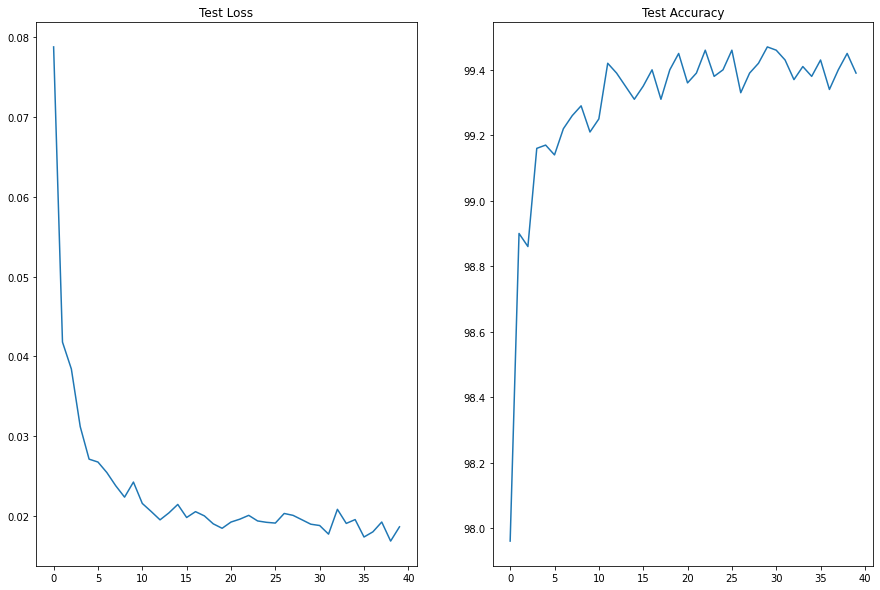

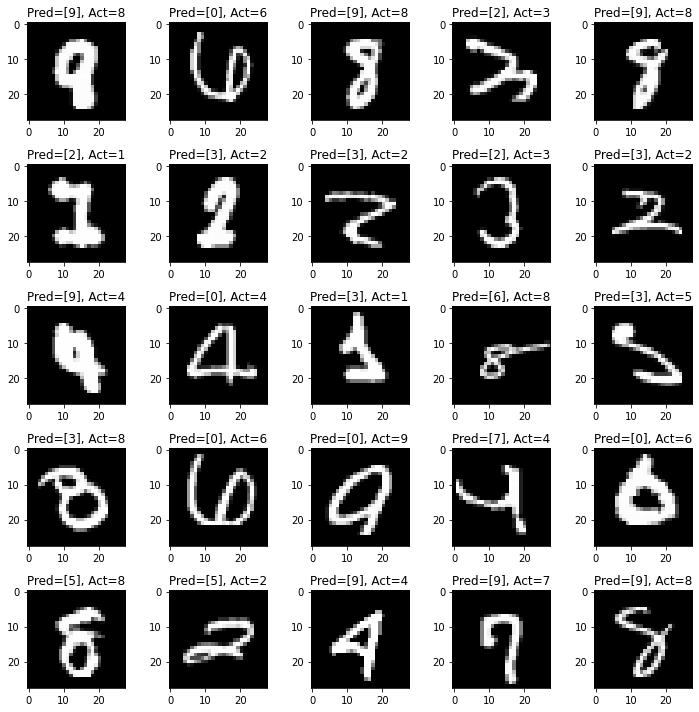

In [ ]:
without_L1L2()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1528233140707016 Batch_id=468 Accuracy=86.38: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0932, Accuracy: 9774/10000 (97.74%)

EPOCH: 1


Loss=0.07011411339044571 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9868/10000 (98.68%)

EPOCH: 2


Loss=0.09467647969722748 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.12530411779880524 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.027760349214076996 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.08712226152420044 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.018713688477873802 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.02066630870103836 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.04223160073161125 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.050302404910326004 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.02056741714477539 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.028836790472269058 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.048460185527801514 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.061225343495607376 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.06983646750450134 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.03836861625313759 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.038579560816287994 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.03365126997232437 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.02390301413834095 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.06088154762983322 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.015856953337788582 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.09745503216981888 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.05941414088010788 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.0293829757720232 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.07900393754243851 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.016934648156166077 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.09536580741405487 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

EPOCH: 27


Loss=0.0703989788889885 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

EPOCH: 28


Loss=0.07184616476297379 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.026424583047628403 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.08730160444974899 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.015170203521847725 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.03975848853588104 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Loss=0.05736558884382248 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)

EPOCH: 34


Loss=0.013755793683230877 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.05317704379558563 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 36


Loss=0.03299403563141823 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 37


Loss=0.04900441691279411 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)

EPOCH: 38


Loss=0.024335037916898727 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.009210729040205479 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]



Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)



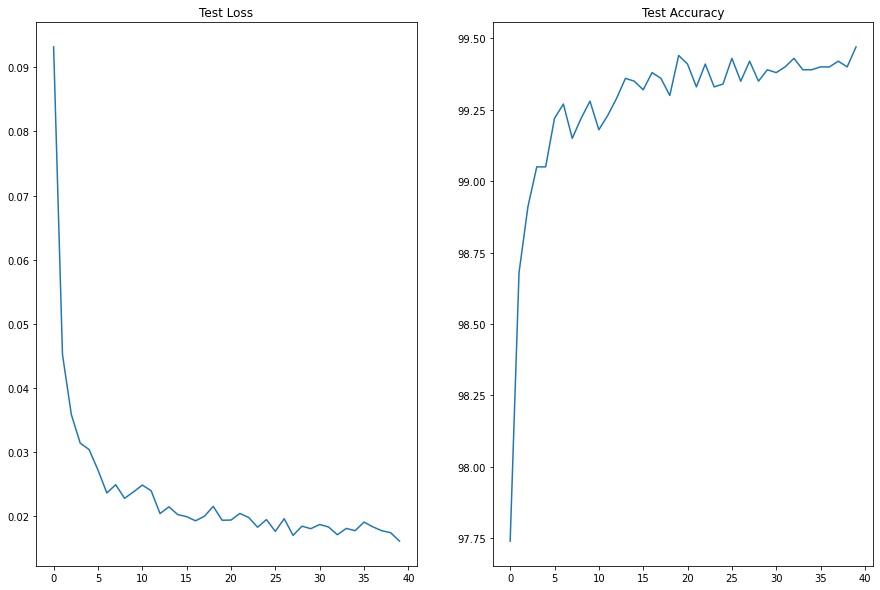

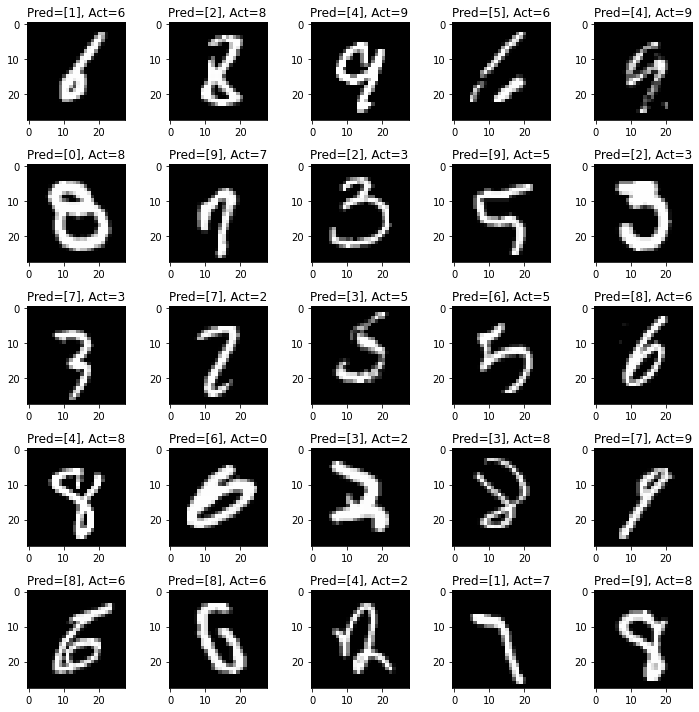

In [ ]:
with_L1()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12293087691068649 Batch_id=468 Accuracy=88.06: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0779, Accuracy: 9829/10000 (98.29%)

EPOCH: 1


Loss=0.07187335938215256 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9875/10000 (98.75%)

EPOCH: 2


Loss=0.175043523311615 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.12494312226772308 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.06905224174261093 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.14055746793746948 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.07520419359207153 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9861/10000 (98.61%)

EPOCH: 7


Loss=0.09265755116939545 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9877/10000 (98.77%)

EPOCH: 8


Loss=0.08267127722501755 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.12958788871765137 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9901/10000 (99.01%)

EPOCH: 10


Loss=0.058252494782209396 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9870/10000 (98.70%)

EPOCH: 11


Loss=0.10806791484355927 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9872/10000 (98.72%)

EPOCH: 12


Loss=0.04444889724254608 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9903/10000 (99.03%)

EPOCH: 13


Loss=0.07372654229402542 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.05080989748239517 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9891/10000 (98.91%)

EPOCH: 15


Loss=0.09009082615375519 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9902/10000 (99.02%)

EPOCH: 16


Loss=0.10062667727470398 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9897/10000 (98.97%)

EPOCH: 17


Loss=0.08935704082250595 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9909/10000 (99.09%)

EPOCH: 18


Loss=0.12283565104007721 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9853/10000 (98.53%)

EPOCH: 19


Loss=0.11035682260990143 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9848/10000 (98.48%)

EPOCH: 20


Loss=0.06715837866067886 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9886/10000 (98.86%)

EPOCH: 21


Loss=0.0460699126124382 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9891/10000 (98.91%)

EPOCH: 22


Loss=0.09565842151641846 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9888/10000 (98.88%)

EPOCH: 23


Loss=0.07459723204374313 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9884/10000 (98.84%)

EPOCH: 24


Loss=0.09324387460947037 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9897/10000 (98.97%)

EPOCH: 25


Loss=0.07008709013462067 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9892/10000 (98.92%)

EPOCH: 26


Loss=0.10319472849369049 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9907/10000 (99.07%)

EPOCH: 27


Loss=0.041245073080062866 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9905/10000 (99.05%)

EPOCH: 28


Loss=0.11083097755908966 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9899/10000 (98.99%)

EPOCH: 29


Loss=0.032561045140028 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9881/10000 (98.81%)

EPOCH: 30


Loss=0.07555924355983734 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9890/10000 (98.90%)

EPOCH: 31


Loss=0.07219773530960083 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9897/10000 (98.97%)

EPOCH: 32


Loss=0.05349098518490791 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9902/10000 (99.02%)

EPOCH: 33


Loss=0.09238402545452118 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9905/10000 (99.05%)

EPOCH: 34


Loss=0.1000676155090332 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9845/10000 (98.45%)

EPOCH: 35


Loss=0.033524610102176666 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9893/10000 (98.93%)

EPOCH: 36


Loss=0.06166740879416466 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9880/10000 (98.80%)

EPOCH: 37


Loss=0.041602108627557755 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9890/10000 (98.90%)

EPOCH: 38


Loss=0.0677681639790535 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9881/10000 (98.81%)

EPOCH: 39


Loss=0.0638224184513092 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.0574, Accuracy: 9867/10000 (98.67%)



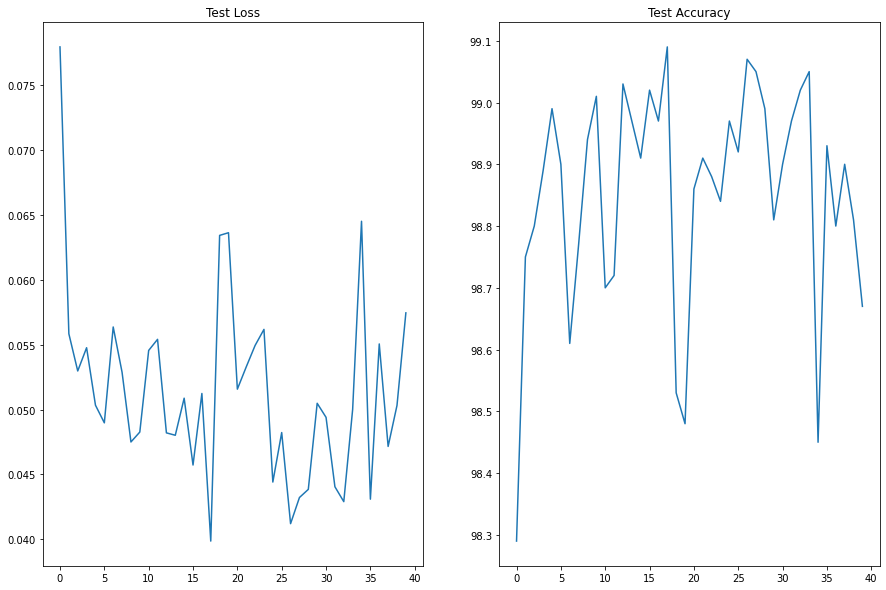

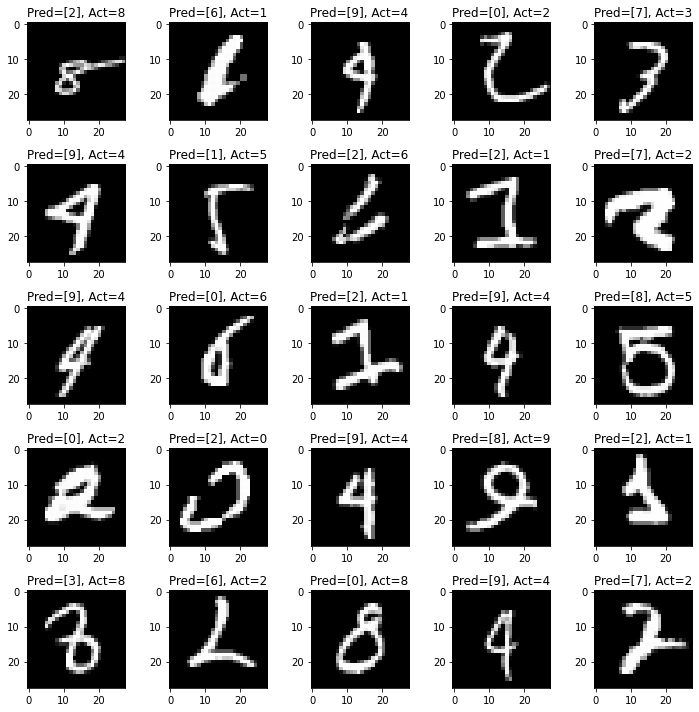

In [ ]:
with_L2()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07564064115285873 Batch_id=468 Accuracy=86.75: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0917, Accuracy: 9806/10000 (98.06%)

EPOCH: 1


Loss=0.11142656207084656 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.07402710616588593 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.06242896243929863 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.0768638476729393 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.07149291783571243 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9869/10000 (98.69%)

EPOCH: 6


Loss=0.04414284601807594 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.09570178389549255 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.09080050140619278 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


Loss=0.04175134375691414 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9874/10000 (98.74%)

EPOCH: 10


Loss=0.06692066788673401 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9864/10000 (98.64%)

EPOCH: 11


Loss=0.11210887879133224 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Loss=0.12356876581907272 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9903/10000 (99.03%)

EPOCH: 13


Loss=0.0633612796664238 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9860/10000 (98.60%)

EPOCH: 14


Loss=0.059930868446826935 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9847/10000 (98.47%)

EPOCH: 15


Loss=0.062193986028432846 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9892/10000 (98.92%)

EPOCH: 16


Loss=0.07762624323368073 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9903/10000 (99.03%)

EPOCH: 17


Loss=0.0795457512140274 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9885/10000 (98.85%)

EPOCH: 18


Loss=0.07149359583854675 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9905/10000 (99.05%)

EPOCH: 19


Loss=0.05428242310881615 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9890/10000 (98.90%)

EPOCH: 20


Loss=0.07351013273000717 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9877/10000 (98.77%)

EPOCH: 21


Loss=0.054429903626441956 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9827/10000 (98.27%)

EPOCH: 22


Loss=0.06267853826284409 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9880/10000 (98.80%)

EPOCH: 23


Loss=0.12728047370910645 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9877/10000 (98.77%)

EPOCH: 24


Loss=0.05202537402510643 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9893/10000 (98.93%)

EPOCH: 25


Loss=0.08809839189052582 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9883/10000 (98.83%)

EPOCH: 26


Loss=0.06166559457778931 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9852/10000 (98.52%)

EPOCH: 27


Loss=0.04994481801986694 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9903/10000 (99.03%)

EPOCH: 28


Loss=0.06465037167072296 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9898/10000 (98.98%)

EPOCH: 29


Loss=0.10306989401578903 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9911/10000 (99.11%)

EPOCH: 30


Loss=0.06948386877775192 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9919/10000 (99.19%)

EPOCH: 31


Loss=0.038888972252607346 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9888/10000 (98.88%)

EPOCH: 32


Loss=0.07863687723875046 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9916/10000 (99.16%)

EPOCH: 33


Loss=0.05718312785029411 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9904/10000 (99.04%)

EPOCH: 34


Loss=0.10694264620542526 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9910/10000 (99.10%)

EPOCH: 35


Loss=0.06275657564401627 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9878/10000 (98.78%)

EPOCH: 36


Loss=0.05557600408792496 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9874/10000 (98.74%)

EPOCH: 37


Loss=0.06811061501502991 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9885/10000 (98.85%)

EPOCH: 38


Loss=0.1626538187265396 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9890/10000 (98.90%)

EPOCH: 39


Loss=0.07853084057569504 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]



Test set: Average loss: 0.0444, Accuracy: 9903/10000 (99.03%)



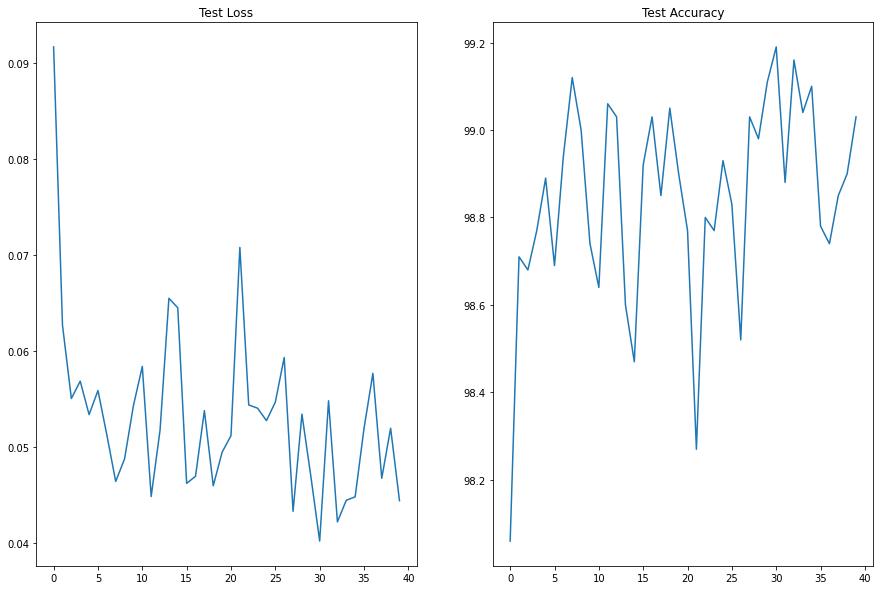

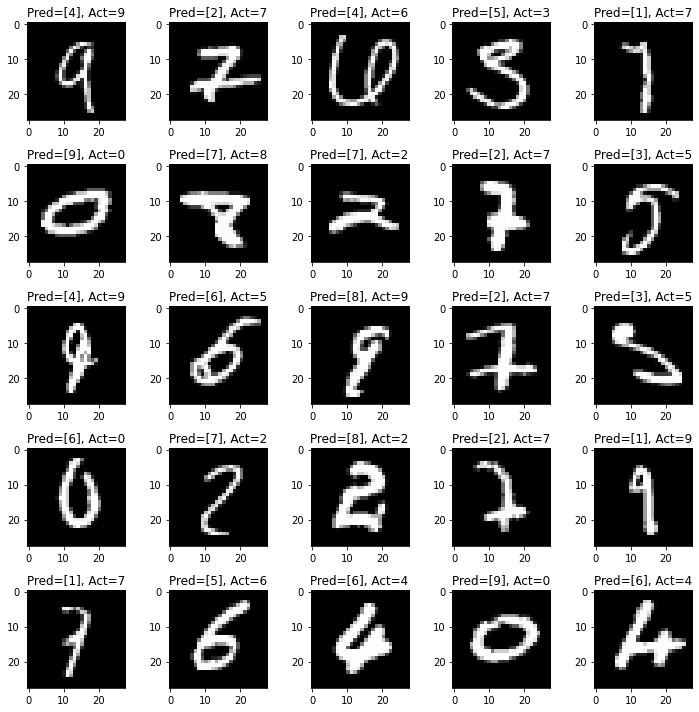

In [ ]:
with_L1_L2()

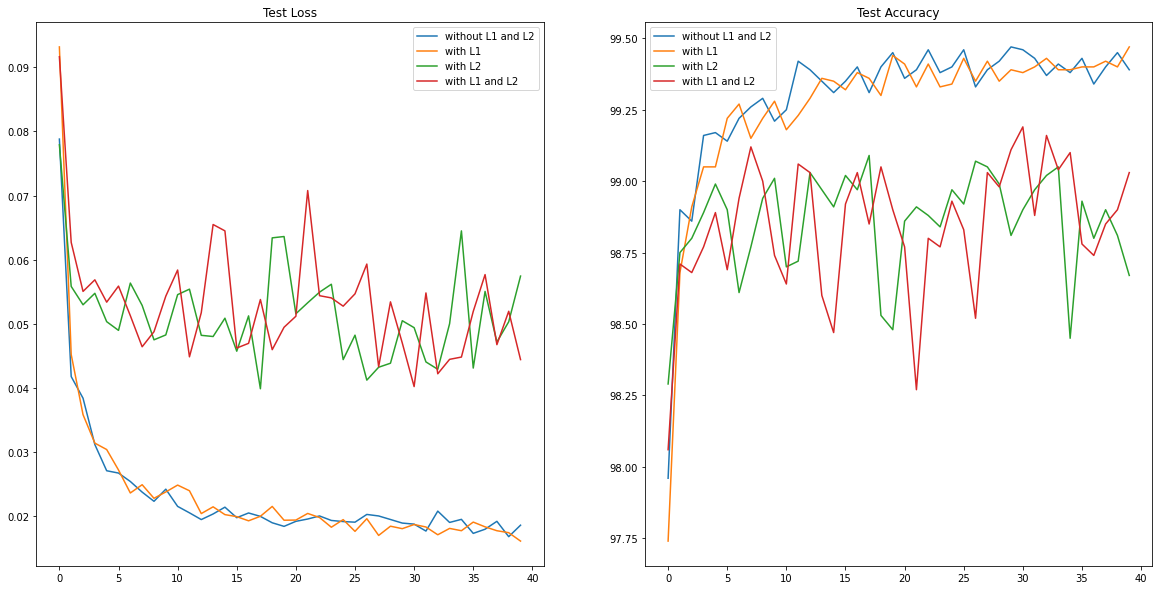

In [ ]:

fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(test_without_L1L2_Loss, label='without L1 and L2')
axs[0].plot(test_with_L1_Loss, label='with L1 ')
axs[0].plot(test_with_L2_Loss, label='with L2 ')
axs[0].plot(test_with_L1L2_Loss, label='with L1 and L2 ')
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_without_L1L2_acc, label='without L1 and L2')
axs[1].plot(test_with_L1_acc, label='with L1 ')
axs[1].plot(test_with_L2_acc, label='with L2')
axs[1].plot(test_with_L1L2_acc, label='with L1 and L2 ')
axs[1].set_title("Test Accuracy")
axs[1].legend()